# CNNs: Better classifiers with Transfer Learning

This notebook how we can use transfer learning to obtain better neural networks.

In practice, very few people train an entire CNN from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

**The two major transfer learning scenarios look as follows:**

- **Finetuning the ConvNet:** Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
import torchvision.transforms as transforms
import time

In [2]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 1.3 MB/s eta 0:00:00


In [3]:
from ignite.handlers import FastaiLRFinder
from ignite.engine import create_supervised_trainer

In [4]:
DEVICE = 'cuda'
BATCH_SIZE = 64

### Helper functions

In [5]:
def plot_accuracy(stats, title=None):

  epochs = [item['epoch'] for item in stats]
  train_accs = [item['train_acc'] for item in stats]
  val_accs = [item['val_acc'] for item in stats]

  plt.plot(epochs, train_accs, label='Train Acc')
  plt.plot(epochs, val_accs, label=f'Val Acc [Best: {max(val_accs):.2f}%]')
  plt.legend()

  if title:
    plt.title(title)

In [6]:
def eval_accuracy(model, loader):

    '''
    Measure the accuracy of the given model on the provided dataloader
    '''

    epoch_acc = 0

    model.eval()

    num_corr_pred = 0
    num_total_pred = 0

    with torch.no_grad():

        for x, y in loader:

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)

            top_pred = y_pred.argmax(1)
            num_corr_pred += (top_pred == y).sum()
            num_total_pred += len(y)

    acc = num_corr_pred / num_total_pred * 100

    return acc.item()

In [7]:
def train(model, train_loader, optimizer, criterion, num_epochs, val_loader=None):

  '''
  Trains the model on the dataloader for a given number of epochs
   '''

  print('===== Start training ===== \n')

  model.train()

  start = time.time()

  stats = []

  for epoch in range(1, num_epochs+1):

    epoch_loss = 0

    for x, y in train_loader:

      optimizer.zero_grad()

      x = x.to(DEVICE)
      y = y.to(DEVICE)

      y_pred = model(x)

      loss = criterion(y_pred, y)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    print(f'[{epoch}] Loss: {epoch_loss:.3f}')

    if epoch % 5 == 0:
      train_acc = eval_accuracy(model, train_loader)
      if val_loader:
        val_acc = eval_accuracy(model, val_loader)
        print(f'[{epoch}] Train Acc: {train_acc:.2f}%  /  Val Acc: {val_acc:.2f}%')
        stats.append({'epoch': epoch, 'train_acc': train_acc, 'val_acc': val_acc})
      else:
        print(f'[{epoch}] Train Acc: {train_acc:.2f}%')
        stats.append({'epoch': epoch, 'train_acc': train_acc})


  end = time.time()
  elapsed_time = end - start

  print()
  print('===== Finished training ===== ')
  print(f'Elapsed time in minutes: {elapsed_time/60:.2f}')

  return stats


### Prepare the datasets and dataloaders

The Flowers102 dataset is composed of three subsets (train, val and test). <br/>
In this code block we prepare the dataloaders for those three subsets.

In [8]:
train_transforms = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.Resize(256),
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.Flowers102('data/', download=True, split='train', transform=train_transforms)
val_dataset = torchvision.datasets.Flowers102('data/', download=True, split='val', transform=test_transforms)
test_dataset = torchvision.datasets.Flowers102('data/', download=True, split='test', transform=test_transforms)

100%|██████████| 344862509/344862509 [00:12<00:00, 28065771.09it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 356992.30it/s]


100%|██████████| 14989/14989 [00:00<00:00, 10274296.89it/s]


In [9]:
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

## ConvNet as fixed feature extractor

### Prepare the pretrained Alex model



First, let's download a pretrained AlexNet model from PyTorch Hub. Like most CNN models, the model was trained on the ImageNet dataset which has 1000 classes.

In [10]:
# Important: Don't forget setting pretrained=True, otherwise the model will be initialized with random weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 127MB/s]


In the first part of this tutorial, our goal will be to train the classification head but keep the weights of the feature extractor fixed. To accomplish this, we first have to expect how we can access the classification head and the feature extractor in the model.

As can be seen below, the classification head is referred to as "classifier" and the feature extractor is referred to as "features".

In [11]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

As the network outputs a 1000-dimensional vector, we have to modify the final linear layer to output 102 classes.

In [12]:
model.classifier[-1] = nn.Linear(4096, 102)

In [13]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Furthermore, to reduce the memory footprint and speed-up training, we will disable the gradien computation for the weights in the feature extraction head. As we don't want to update these weights, we also don't need their gradients.

In [14]:
# Turn-off the .requires_grad attributes for all params in the feature extraction head
for params in model.features.parameters():
		params.requires_grad = False

In [15]:
model = model.to(DEVICE)

### LR range test

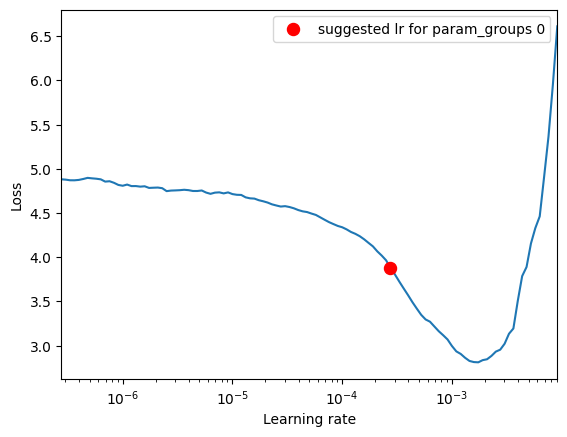

0.0002754228703338166

In [16]:
start_lr = 1e-7
end_lr = 1e+1
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainer = create_supervised_trainer(model, optimizer, criterion, DEVICE)

lr_finder = FastaiLRFinder()
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save, start_lr=start_lr, end_lr=end_lr, num_iter=200) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

# Get lr_finder results
lr_finder.get_results()

# Plot lr_finder results (requires matplotlib)
lr_finder.plot()

# get lr_finder suggestion for lr
lr_finder.lr_suggestion()

### Train the model

In [19]:
num_epochs = 50

# Important: Configure the optimizer to only update the weights of the classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [20]:
stats = train(model, train_loader, optimizer, criterion, num_epochs, val_loader)

===== Start training ===== 

[1] Loss: 23.854
[2] Loss: 19.199
[3] Loss: 15.122
[4] Loss: 13.899
[5] Loss: 11.090
[5] Train Acc: 87.35%  /  Val Acc: 76.86%
[6] Loss: 7.634
[7] Loss: 6.717
[8] Loss: 6.679
[9] Loss: 6.198
[10] Loss: 5.437
[10] Train Acc: 92.55%  /  Val Acc: 77.45%
[11] Loss: 5.520
[12] Loss: 5.932
[13] Loss: 3.861
[14] Loss: 4.404
[15] Loss: 4.019
[15] Train Acc: 91.67%  /  Val Acc: 77.55%
[16] Loss: 3.479
[17] Loss: 4.419
[18] Loss: 4.137
[19] Loss: 4.211
[20] Loss: 4.148
[20] Train Acc: 95.10%  /  Val Acc: 77.84%
[21] Loss: 3.414
[22] Loss: 3.456
[23] Loss: 3.130
[24] Loss: 3.889
[25] Loss: 3.563
[25] Train Acc: 95.59%  /  Val Acc: 78.43%
[26] Loss: 3.190
[27] Loss: 2.805
[28] Loss: 2.890
[29] Loss: 2.205
[30] Loss: 2.816
[30] Train Acc: 95.39%  /  Val Acc: 78.63%
[31] Loss: 2.068
[32] Loss: 2.366
[33] Loss: 2.982
[34] Loss: 2.527
[35] Loss: 2.855
[35] Train Acc: 95.98%  /  Val Acc: 77.55%
[36] Loss: 2.491
[37] Loss: 2.789
[38] Loss: 2.364
[39] Loss: 1.715
[40] Loss: 2

### Plot accuracy



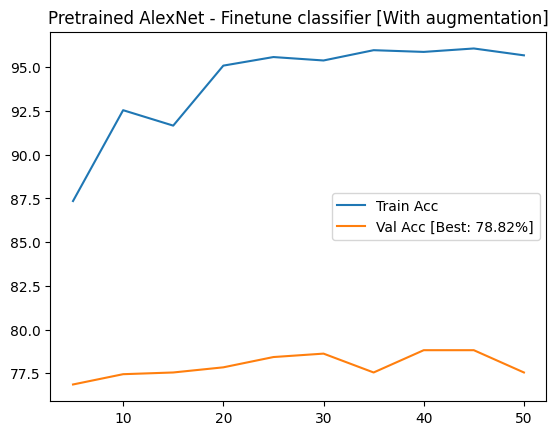

In [21]:
plot_accuracy(stats, title='Pretrained AlexNet - Finetune classifier [With augmentation]')

In [22]:
test_acc = eval_accuracy(model, test_loader)
print(f'Accuracy on the test set (final model): {test_acc:.2f}%')

Accuracy on the test set (final model): 73.22%


## Finetune the entire Conv Net

The following cells show how to train the entire conv net. The training procedure is similar to training a neural network from scratch. The only difference is that pretrained weights are used.

In [23]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[-1] = nn.Linear(4096, 102)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
model = model.to(DEVICE)

In [25]:
num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [26]:
stats = train(model, train_loader, optimizer, criterion, num_epochs, val_loader)

===== Start training ===== 

[1] Loss: 72.448
[2] Loss: 49.484
[3] Loss: 27.041
[4] Loss: 18.998
[5] Loss: 14.263
[5] Train Acc: 83.82%  /  Val Acc: 72.06%
[6] Loss: 9.782
[7] Loss: 8.761
[8] Loss: 6.920
[9] Loss: 5.951
[10] Loss: 5.902
[10] Train Acc: 92.35%  /  Val Acc: 75.10%
[11] Loss: 4.833
[12] Loss: 4.221
[13] Loss: 4.762
[14] Loss: 4.868
[15] Loss: 3.779
[15] Train Acc: 93.14%  /  Val Acc: 74.71%
[16] Loss: 4.174
[17] Loss: 3.815
[18] Loss: 3.334
[19] Loss: 3.206
[20] Loss: 4.616
[20] Train Acc: 92.94%  /  Val Acc: 72.84%
[21] Loss: 4.600
[22] Loss: 3.039
[23] Loss: 3.295
[24] Loss: 3.460
[25] Loss: 3.715
[25] Train Acc: 93.73%  /  Val Acc: 72.45%
[26] Loss: 2.611
[27] Loss: 2.798
[28] Loss: 3.776
[29] Loss: 3.526
[30] Loss: 3.075
[30] Train Acc: 95.10%  /  Val Acc: 77.84%
[31] Loss: 2.868
[32] Loss: 2.549
[33] Loss: 2.684
[34] Loss: 3.159
[35] Loss: 2.790
[35] Train Acc: 94.80%  /  Val Acc: 74.80%
[36] Loss: 2.753
[37] Loss: 2.263
[38] Loss: 2.604
[39] Loss: 2.047
[40] Loss: 2

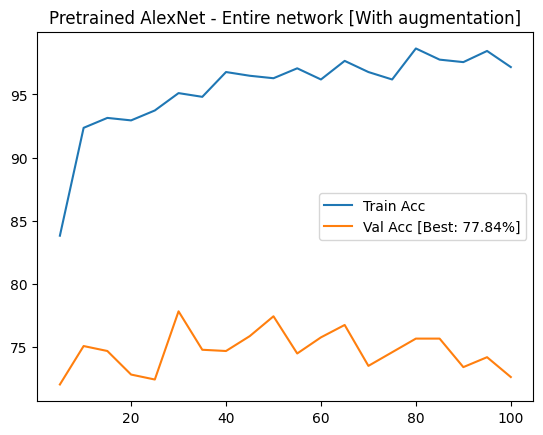

In [27]:
plot_accuracy(stats, title='Pretrained AlexNet - Entire network [With augmentation]')

In [28]:
test_acc = eval_accuracy(model, test_loader)
print(f'Accuracy on the test set (final model): {test_acc:.2f}%')

Accuracy on the test set (final model): 69.46%
